# Predictive coding of an $M$-dimensional signal in an $N$-dimensional network

Here, we derive and simulate dynamical equations for an N-dimensional network of neurons based on the derivations from the single neuron [1].

## Loading a greyscale images as input (plus animate them as video, see below)


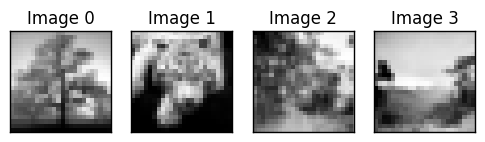

In [74]:
%matplotlib inline
import matplotlib.image as img
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from time import sleep
from matplotlib import animation, rc
from IPython.display import HTML
from scipy import ndimage,misc

ONE_IMG = False
dtms    = 0.1   #dt in [ms]
lenstim = int(7500 / dtms) #[ms]
imgsize = 24

if ONE_IMG:
    files = [ './img/tree.png']
else:
    files = [ './img/tree.png',
              './img/tiger.png',
              './img/landsc2.png',
              './img/landsc1.png' ]

fig, ax = plt.subplots(1,len(files))
images = []

for ind, afile in enumerate(files):
    temp = img.imread(afile)
    images.append(misc.imresize(temp, (imgsize,imgsize)))
    ax[ind].imshow(images[ind], cmap="gray", interpolation='none')
    ax[ind].set_title("Image "+str(ind))
    ax[ind].set_xticks([imgsize])
    ax[ind].set_yticks([imgsize])

#ani = animation.FuncAnimation(fig, animate, init_func=init, frames=range(len(files)), interval=lenstim*dtms)
plt.show()
#ani.save('./videos/imgs.mp4')

## Generate input vectors from images

First, we need to flatten image matrices to vectors. To examplify this task, we create a 4x4 test matrix and our goal is to flatten the matrix to a 16-dim. vector. The NumPy function `numpy.ravel()` is the function that does the job.

In [75]:
test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
flat = np.ravel(test)
print("Test matrix:\n", test,"\n\nFlat array:\n", flat)

Test matrix:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]] 

Flat array:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Now we move on to define a function, which loads images from a given list and generates a matrix containing column vectors of images. Each image can be repeated by specifying a repeat duration.

In [76]:
import math

def generate_input(image_list, repeat=1000):
    N = len(image_list)*repeat
    M = image_list[0].size
    print("Generating input...")
    print("Input dims:",M,N)
    input_mat = np.zeros((N,M))
    for ind, image in enumerate(image_list):
        samplen = int(len(image_list)/10+1)
        if math.fmod(ind,samplen)==0:
            print("Image", ind)
        flat = np.ravel(image)
        start = ind*repeat
        end =(ind+1)*repeat
        input_mat[start:end,:] = np.tile(flat,(repeat,1))
    print("Done")
    return input_mat.T

In [77]:
raw_input = generate_input(images, lenstim)

Generating input...
Input dims: 576 300000
Image 0
Image 1
Image 2
Image 3
Done


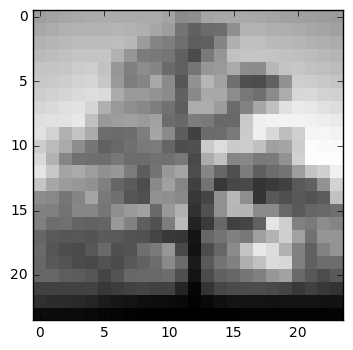

In [78]:
plt.imshow(raw_input[:,3900].reshape(imgsize,imgsize),cmap="gray", interpolation='none')
#plt.colorbar()

## Simulation code with images input loaded

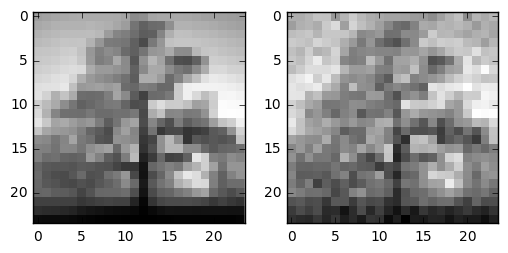

t: 0.0 	error: 10.0077908905
t: 1.0 	error: 7.65961211089
t: 2.0 	error: 6.84818446872
t: 3.0 	error: 6.55156743262
t: 4.0 	error: 6.44161234426
t: 5.0 	error: 6.42364672771
t: 6.0 	error: 6.39616147553
t: 7.0 	error: 6.37664869562
t: 8.0 	error: 8.19149493847
t: 9.0 	error: 8.12513677643
t: 10.0 	error: 8.11085993936
t: 11.0 	error: 8.09858185679
t: 12.0 	error: 8.10669453643
t: 13.0 	error: 8.12534936107
t: 14.0 	error: 8.10376870609
t: 15.0 	error: 10.9658743004
t: 16.0 	error: 10.1639723095
t: 17.0 	error: 9.9282642041
t: 18.0 	error: 9.83275832288
t: 19.0 	error: 9.82130855875
t: 20.0 	error: 9.81941634344
t: 21.0 	error: 9.79130423654
t: 22.0 	error: 9.80209371674
t: 23.0 	error: 12.4619256234
t: 24.0 	error: 12.398717916
t: 25.0 	error: 12.3806895495
t: 26.0 	error: 12.3873321678
t: 27.0 	error: 12.3888255553
t: 28.0 	error: 12.4038178252
t: 29.0 	error: 12.3888708629


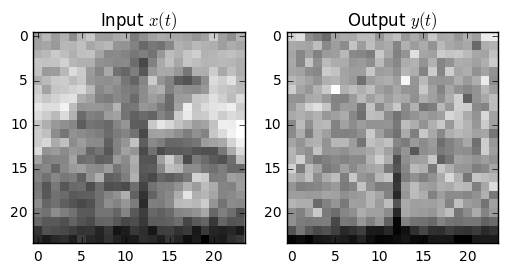

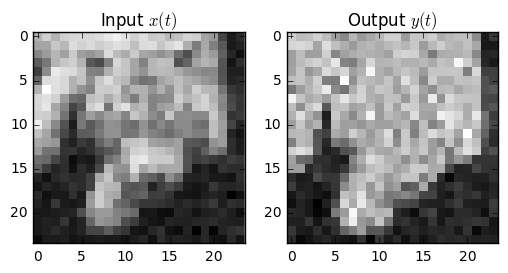

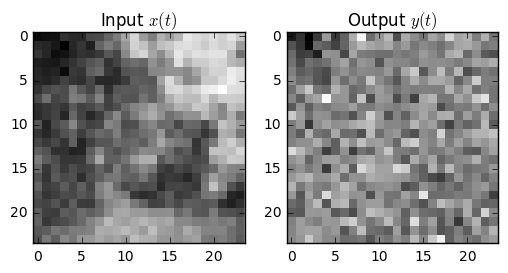

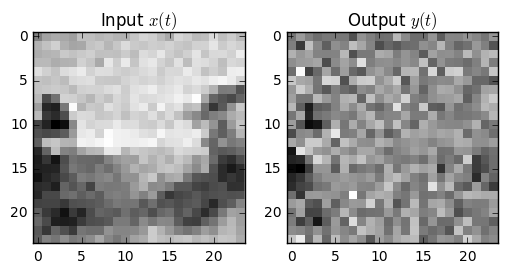

Spikes/time: 17.3610532407
Mean inverse ISI: 8.68055555556


In [79]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from numpy import linalg as LA
#from cmaps import nice_cmap
from matplotlib.legend_handler import HandlerLine2D

" Parameters/containers "
VERBOSE = False                     # Printout
PLOT_INPUT = True                   # Plot input
NOISE_FREE = False                  # Noise-free case

" Network sizes "
M       = raw_input.shape[0]        # Number of signal dimensions
N       = 2*M                       # Number of neurons
nsteps  = raw_input.shape[1]        # Number of time steps
dt      = 0.0001                    # Integration time step
T       = nsteps*dt                 # Total duration
time    = np.arange(0, T, dt)       # Time array
V       = np.zeros((N,len(time)))   # Membrane voltage
a       = 1.                        # Input amplitude
raw     = np.array(raw_input/255.)  # Raw signal (normalized)
x       = np.array(raw)             # Input signal
" Signal noise "
if not NOISE_FREE:
    x += rand.normal(0.0,0.05,x.shape) ## Adding white noise
x[:,0]  = np.zeros(M)               # First image to zero

y       = np.zeros((M,len(time)))   # Decoder
o       = np.zeros((N,len(time)))   # Spikes
st      = []                        # Spike times + index
rate    = np.zeros((N,len(time)))   # Firing rate
mu      = 0.00001/N                 # Regularization constant
angN    = np.linspace(0, 2*np.pi, num=N, endpoint=False) # N angles in [0,2PI) equally spaced 
angM    = np.linspace(0, np.pi, num=M, endpoint=False)   # M angles in [0,PI) equally spaced 
D       = 0.01*(np.eye(M,N) - np.eye(M,N,k=M))##
#for ind in range(M):
#    D[ind,:]     = 0.01*np.cos(4.*(angN-angM[ind]))

#D       = 0.1*rand.normal(.0, 1., (M,N))#/N
W       = (D.T).dot(D) + mu*np.eye(N)
Thr     = np.diag((D.T).dot(D))/2 + (mu/2)*np.ones(N)      # Threshold
decay   = 1.                        # Decay constant
if VERBOSE:
    print("Run simulation",T,"seconds.")
    evals, evecs = LA.eigh(W)
    print("Recurrent weights:", W)
    print("Readout weights:", D)
    print("Spectral radius:", evals)
    print("Threshold:", Thr) 

" Run this to check input "
if PLOT_INPUT:
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(raw_input[:,1].reshape(imgsize,imgsize),cmap="gray", interpolation='none')
    ax[1].imshow(x[:,1].reshape(imgsize,imgsize),cmap="gray", interpolation='none')
    plt.show()

" Plot current input and output"
def plot_this(i):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(x[:,i].reshape(imgsize,imgsize),cmap="gray", interpolation='none')
    ax[0].set_title("Input $x(t)$")
    ax[1].imshow(y[:,i].reshape(imgsize,imgsize),cmap="gray", interpolation='none')
    ax[1].set_title("Output $y(t)$")
    plt.show()
    
" Squared error of reconstruction"
def L(i):
    return np.sqrt(((raw[:,i] - y[:,i]).T).dot(raw[:,i] - y[:,i]))
    
" Voltage ODE "
def dV(i, spike):
    return - V[:,i] + (D.T).dot((x[:,i]+(x[:,i+1]-x[:,i])/dt)) - W.dot(spike)/dt

" Decoder ODE "
def dy(i, spike):
    return - y[:,i] + D.dot(spike)/dt
" Rate ODE "
def dr(i, spike):
    return - rate[:,i] + spike/dt

" List difference function "
def diff(a):
    return [a[i+1]-a[i] for i in range(len(a)-1)]

" Randomly choose one spike "
def rand_one(array):
    return rand.choice(np.ravel(np.nonzero(array)), 1)[0]

" Update step "
def step(i):
    if np.sum(o[:,i] > 0):
        st.append(t)
    " Potential (Euler) "
    V[:,i+1] = V[:,i] + dt * dV(i, o[:,i])   
    " Check spikes "    
    o[:,i+1] = (V[:,i+1] > Thr)
    if np.sum(o[:,i+1])>0:
        specfl = rand_one(o[:,i+1])
        o[:, i+1] = np.eye(N)[specfl]
    " Decoder (Euler) "
    y[:,i+1] = y[:,i] + dt * dy(i, o[:,i+1])
    " Estimate firing rate (Euler) "
    rate[:,i+1] = rate[:,i] + dt * dr(i, o[:,i+1])
    
" Simulation "
for i,t in enumerate(time[:-1]):
    if math.fmod(i,10000)==0:
        print("t:",t, "\terror:", L(i))
        #plot_this(i)
    step(i)
    if np.sum(o[:,i])>0 and VERBOSE:
        print("Spike time:", t, "@neuron", np.argmax(o[:,i])+1, np.sum(o[:,i]))

plot_this(int(0.25*len(time))-1)
plot_this(int(0.5*len(time))-1)
plot_this(int(0.75*len(time))-1)
plot_this(len(time)-1)
print("Spikes/time:", np.sum(o)/(N*T/2))
print("Mean inverse ISI:", 1./(N*np.mean(diff(st))))

In [80]:
" Plotting "
def plot_fig1():
    npanels = 4
    f, axarr = plt.subplots(npanels, sharex=True)
    K=3
    drawN = N
    lcols = int(math.ceil(drawN/3))
    Rsize = K*drawN+1
    col = plt.get_cmap('rainbow', N)
    excV = plt.get_cmap('Reds', int(0.8*Rsize))
    inhV = plt.get_cmap('Blues', int(0.2*Rsize))
    excR = plt.get_cmap('autumn', int(0.8*Rsize))
    inhR = plt.get_cmap('winter', int(0.2*Rsize))
    f.set_figheight(npanels*2)
    f.set_figwidth(npanels*3)
    #plt.xticks(np.arange(0,1100,20))

    " Panel A: Decoding signal"
    for m in range(3):
        axarr[0].plot(time, x[m,:], c='k', label = 'Signal $x(t)$')
        axarr[0].plot(time, y[m,:], c='r', label ='Decoder $y(t)$')
    axarr[0].set_ylabel("Signal")
    #axarr[0].set_ylim([-0.1, a+0.1])
    axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    " Panel B: Membrane potentials "
    for neuron in range(drawN):
        name = '$V_{'+str(neuron+1)+'}$'
        axarr[1].plot(time, V[neuron,:], color=col(neuron), label = name)
        #else:
            #axarr[1].plot(time, V[neuron,:], color=inhV(Rsize-K*neuron), label = name)
    axarr[1].set_ylabel("Membrane potential")
    axarr[1].plot([0,T],[Thr,Thr], color='#bbbbbb')
    #axarr[1].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)

    " Panel C: Spike raster plot "
    for neuron in range(N):
        name = 'Neuron '+str(neuron+1)
        posy = (1+neuron)*o[neuron, o[neuron,:]==1]
        axarr[2].vlines(time[o[neuron,:]==1], posy-0.5, posy+0.5, label = name)
        #axarr[2].legend(handler_map={spikes: HandlerLine2D(numpoints=1)})
    #axarr[2].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    axarr[2].set_ylim([0, N+1])
    axarr[2].set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    axarr[2].set_yticks(np.arange(spacer,N+1,spacer))

    " Panel D: Firing rate estimates "
    for neuron in range(drawN):
        name = '$r_{'+str(neuron+1)+'}$'
        axarr[3].plot(time, rate[neuron,:], color=col(neuron), label = name)
        #else:
            #axarr[3].plot(time, rate[neuron,:], color=inhR(K*neuron+10), label = name)
    axarr[3].set_ylabel("Firing rate")
    #axarr[3].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    #axarr[3].set_ylim([-1, 25.000])
    plt.xlabel("Time")
    
    return f, axarr

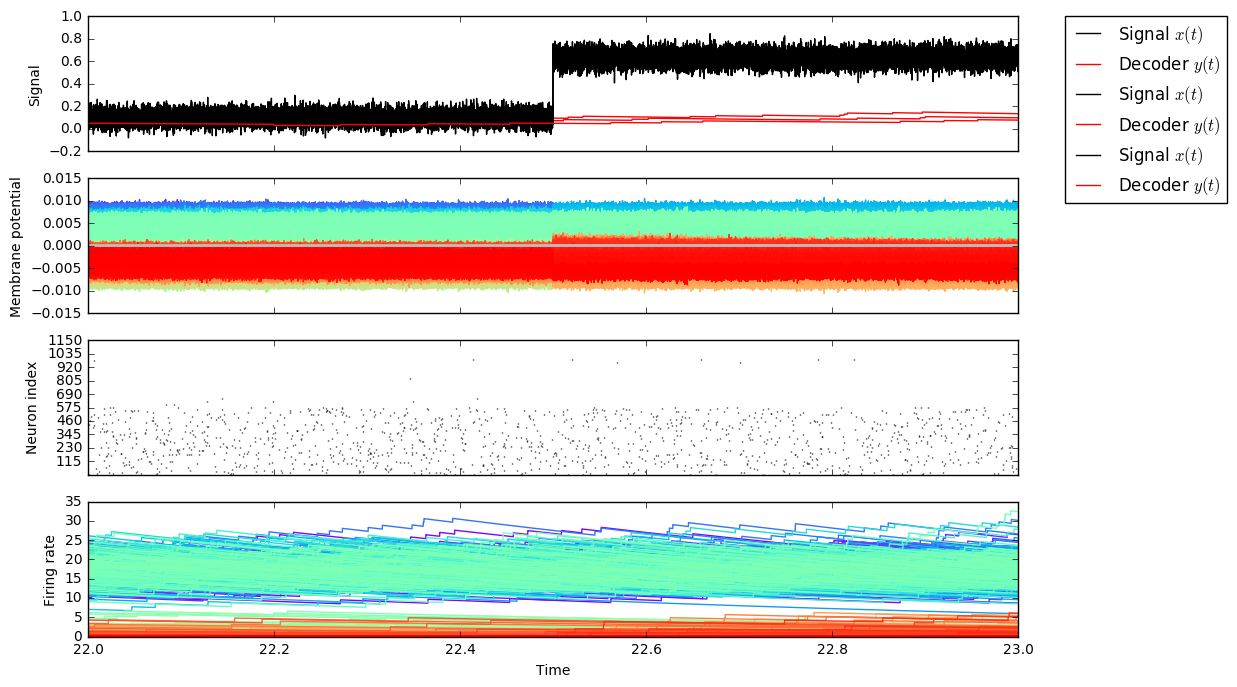

In [81]:
f, ax = plot_fig1()
plt.xlim(22., 23.)
plt.show()

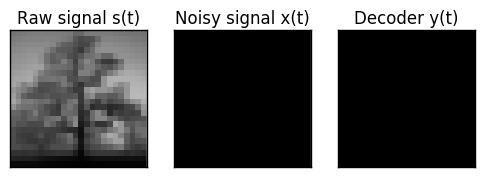

In [82]:
%matplotlib inline
import matplotlib.image as img
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from time import sleep
from matplotlib import animation, rc
from IPython.display import HTML
from scipy import ndimage,misc

fig, ax = plt.subplots(1,3)
skip = 100*int(0.001/dt) ##[ms]
raw_low = raw[:,::skip]
x_low = x[:,::skip]
y_low = y[:,::skip]

implot0 = ax[0].imshow((raw_low[:,10]).reshape(imgsize,imgsize), vmin=0.0, vmax=1.0, cmap="gray",animated=True, interpolation='none')
implot1 = ax[1].imshow((x_low[:,10]).reshape(imgsize,imgsize), vmin=0.0, vmax=1.0, cmap="gray",animated=True, interpolation='none')
implot2 = ax[2].imshow((y_low[:,10]).reshape(imgsize,imgsize), vmin=0.0, vmax=1.0, cmap="gray",animated=True, interpolation='none')
ax[0].set_title("Raw signal s(t)") # $\mathbf{x}(t)$")
ax[1].set_title("Noisy signal x(t)") # $\mathbf{x}(t)$")
ax[2].set_title("Decoder y(t)") # $\mathbf{y}(t)$")
for ind in range(3):
    ax[ind].set_xticks([imgsize])
    ax[ind].set_yticks([imgsize])


def animate(i):
    new_raw = (raw_low[:,i]).reshape(imgsize,imgsize)
    new_x = (x_low[:,i]).reshape(imgsize,imgsize)
    new_y = (y_low[:,i]).reshape(imgsize,imgsize)
    implot0.set_data(new_raw)
    implot1.set_data(new_x)
    implot2.set_data(new_y)
    #implot.autoscale()
    return [implot0, implot1, implot2]

#print(range(y_low.shape[1]))
ani = animation.FuncAnimation(fig, animate, frames=y_low.shape[1], interval=(dt*1000)*skip)
#plt.show()
ani.save('./videos/out.mp4')

In [ ]:
HTML(ani.to_html5_video())

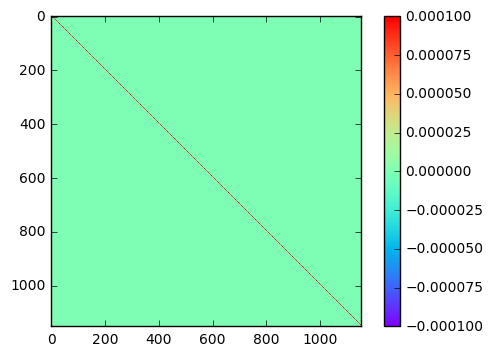

In [ ]:
plt.imshow(W, cmap="rainbow")
plt.colorbar()
plt.show()
plt.imshow(D, cmap="rainbow")
plt.colorbar()
plt.show()